In [29]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path

In [30]:
# path = Path('/kaggle/input/animefacedataset/images')
path = Path('/kaggle/input/atopy-all-data/atopy_data')
len(os.listdir(path))

853

In [31]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [32]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)

In [33]:
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    img = (img - 127.5) / 127.5
    img = tf.image.resize(img, (64, 64))
    return img

In [34]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [35]:
dataset = dataset.shuffle(853).batch(16, drop_remainder=True)

In [36]:
dataset = dataset.prefetch(32)

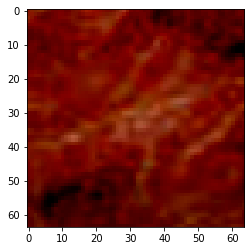

In [37]:
plt.imshow(next(dataset.as_numpy_iterator())[10])

In [38]:
next(dataset.as_numpy_iterator())[:8].shape

(8, 64, 64, 3)

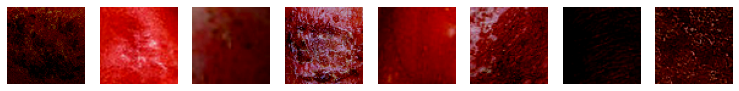

In [39]:
def show(images):
    fig, ax = plt.subplots(1, 8, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:8])

In [40]:
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

In [41]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [42]:
# def critic(input_shape=(64, 64, 3), dim=64, n_downsampling=3):
#     input_ = Input(shape=input_shape)
#     X = conv_layer(32, 5, strides=1,  padding='same')(input_)
#     X = conv_layer(dim, 3)(X)
    
#     for i in range(n_downsampling):
#         X = conv_layer(dim * 2 ** (i+1), 4)(X)
#         X = Dropout(0.4)(X)
#     X = Flatten()(X)
#     X = Dense(1, activation='sigmoid')(X)
#     return keras.models.Model(inputs=input_, outputs=X)

def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [43]:
d = critic()
d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 32, 32, 64)        3200      
_________________________________________________________________
conv_layer_5 (ConvLayer)     (None, 16, 16, 128)       131328    
_________________________________________________________________
conv_layer_6 (ConvLayer)     (None, 8, 8, 256)         524800    
_________________________________________________________________
conv_layer_7 (ConvLayer)     (None, 4, 4, 512)         2098176   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 1)           8193      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0   

In [44]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [45]:
# def generator(input_shape=(100), dim=64, n_upsampling=3):
#     input_ = Input(shape=input_shape)
#     X = Dense(4 * 4 * 32)(input_)
#     X = Reshape((4, 4, 32))(X)
#     X = deconv_layer(dim*8, 5, strides=1, padding='same')(X)
#     for i in range(n_upsampling):
#         X = deconv_layer(dim * 2 ** (n_upsampling-i-1), 5)(X)
        
#     X = Conv2DTranspose(3, 5, strides=2, padding='same')(X)
#     X = Activation('tanh')(X)
#     return keras.models.Model(inputs=input_, outputs=X)
def generator(input_shape=(1, 1, 128), output_channels=3, dim=64, n_upsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [46]:
g = generator()
g.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 1, 128)]       0         
_________________________________________________________________
upsample_block_4 (UpsampleBl (None, 4, 4, 512)         1050112   
_________________________________________________________________
upsample_block_5 (UpsampleBl (None, 8, 8, 256)         2097920   
_________________________________________________________________
upsample_block_6 (UpsampleBl (None, 16, 16, 128)       524672    
_________________________________________________________________
upsample_block_7 (UpsampleBl (None, 32, 32, 64)        131264    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 3)         3075      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 3)         0   

In [47]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [48]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [49]:
EPOCHS = 10
BATCH_SIZE = 16
noise_dim = 128

In [50]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

In [51]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [52]:
seed = tf.random.normal((16, 1, 1, 128))

In [53]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

In [54]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=853//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

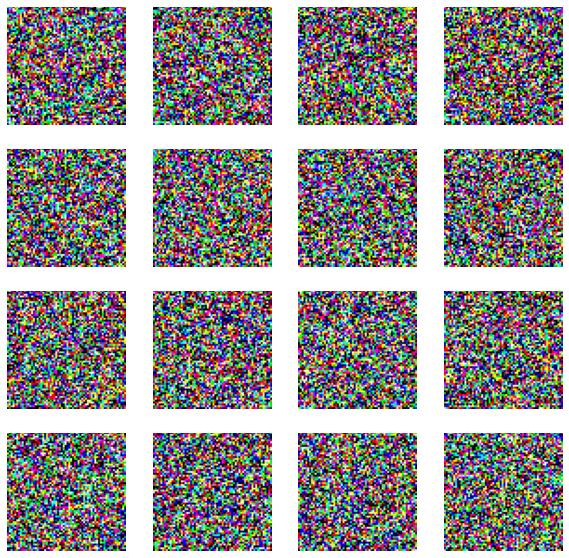

Time for epoch 1 is 9.019433498382568 sec


In [55]:
train(dataset, 1)
# 1 epochs

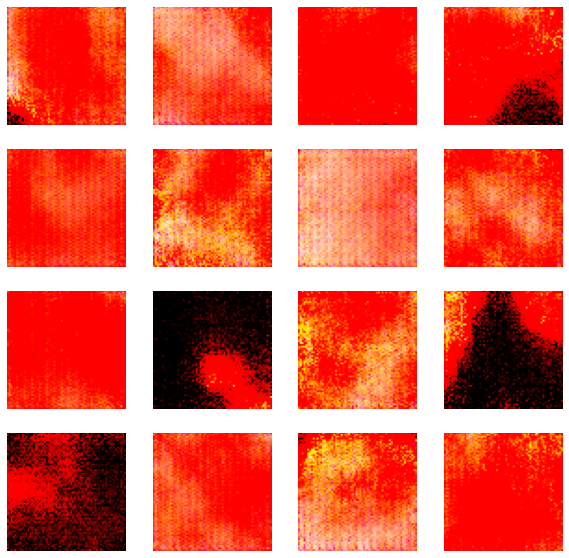

Time for epoch 100 is 3.7129359245300293 sec


In [56]:
train(dataset, 100)
# 1 epochs

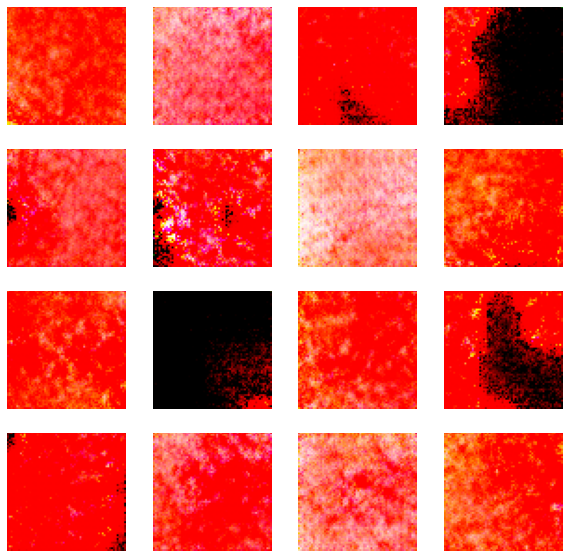

Time for epoch 100 is 3.7398059368133545 sec


In [57]:
train(dataset, 100)
# 1 epochs

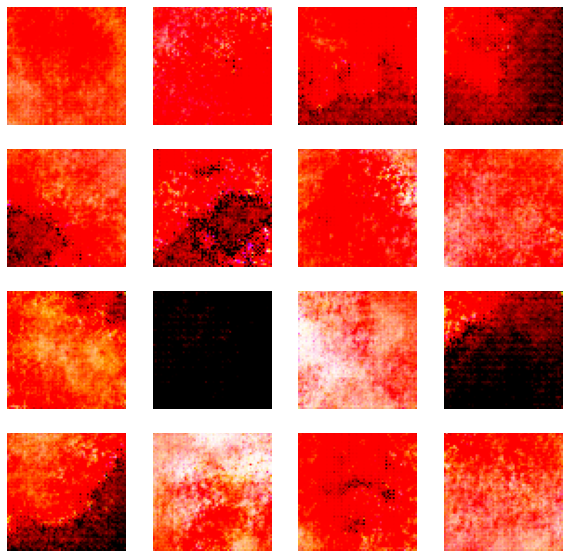

Time for epoch 500 is 3.446484088897705 sec


In [58]:
train(dataset, 500)
# 1 epochs

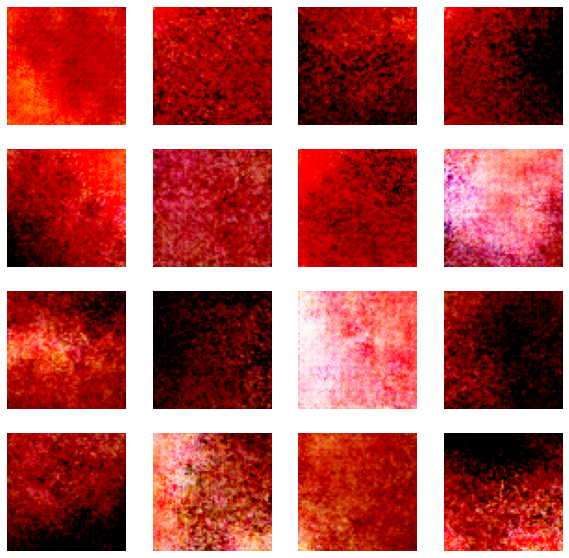

Time for epoch 500 is 3.464594841003418 sec


In [59]:
train(dataset, 500)
# 1 epochs

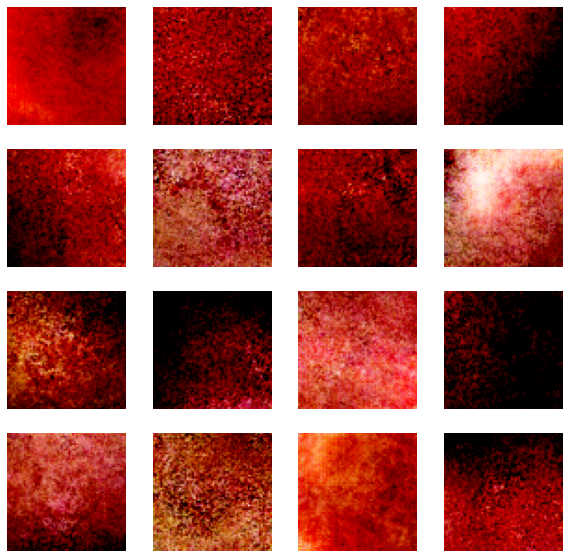

Time for epoch 1000 is 3.442662000656128 sec


In [60]:
train(dataset, 1000)
# 1 epochs

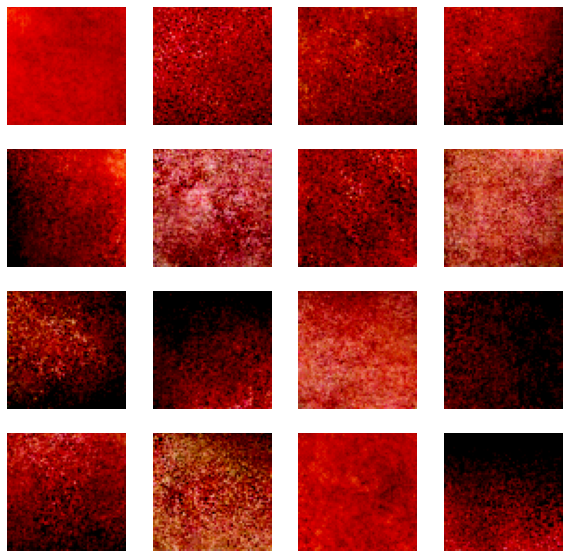

Time for epoch 1000 is 3.7088165283203125 sec


In [61]:
train(dataset, 1000)
# 1 epochs

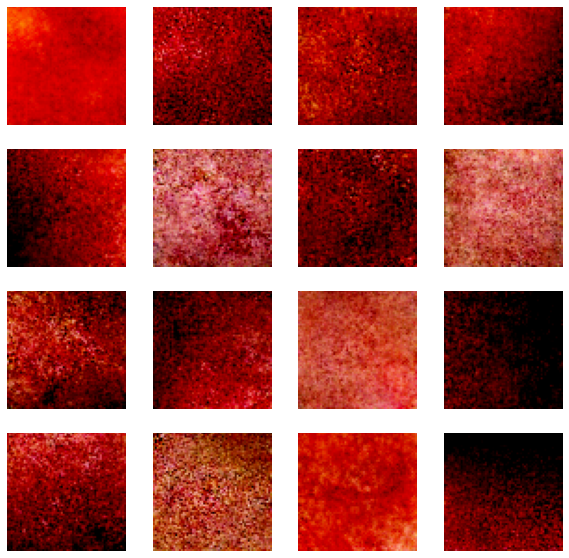

Time for epoch 822 is 6.065129280090332 sec


100%|██████████| 53/53 [00:02<00:00, 18.87it/s]


In [ ]:
train(dataset, 1000)
# 1 epochs

In [ ]:
optG.lr = 1e-4
optD.lr = 1e-4

In [ ]:
train(dataset, 10)

In [ ]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128]))